# Global Wheat Detection

This is the training part of my second attempt to take on the [Global Wheat Detection](kaggle.com/c/global-wheat-detection). My first attempt was bases on Yolov5, which was banned due to licensing issues. This attempt will use EfficientDet. As a starting point, I will be using the [\[Training\] EfficientDet](https://www.kaggle.com/shonenkov/training-efficientdet) notebook by Alex Shonenkov. I will be taking it apart to try to work out how exactly EfficientDet works. The pre-trained checkpoints will be taken from Mathurin Aché's [dataset](https://www.kaggle.com/mathurinache/efficientdet).

## Setup

### Imports
These are the general imports. I will import more specialized modules when working with the network

In [1]:
import torch
import pandas as pd
import numpy as np
from glob import glob
import os
import cv2
import apex
import re
import matplotlib.pyplot as plt
import time
from datetime import datetime
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import random

### Detect OS

First, the operating system has to be selected, because I want to be able to use this notebook on both my Windows machine at home and the Kaggle system

In [2]:
system = os.name
if system == 'posix':
    kaggle = True
    windows = False
    print('running on kaggle')
elif system == 'nt':
    kaggle = False
    windows = True
    print('running on windows')
else:
    print('unknown system')

running on windows


### Select the GPU the Notebook has access to

Because I am going to be developing this notebook while at the same time training my network on my other GPU, I will be limiting the access this notebook has to my secondary GPU in order to make sure it does not interfere with the training process

### APEX

In [3]:
apex_on = True
if apex_on:
    if kaggle:
        ! pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/nvidiaapex/.
if apex_on:
    from apex import amp


## The Dataset

The first goal will be to format the dataset, so it can be used for training by the network. The initial state of the dataset is a CSV file containing a list of images and their respective labels

In [4]:
labels = pd.read_csv('../input/global-wheat-detection/train.csv')

In [5]:
labels

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


The dataset contains the columns:
* `image_id`: the unique identifier for each of the pictures. There is a row for every box, so each picture can occur multiple times
* `width` & `height`: number of pixels of width and height of the pictures
* `bbox`: coordinates for the box. They are in pixels and follow the format \[x_min, y_min, width, height\]
* `source`: source of the picture. The pictures of the wheat were taken by different institutions across the world and the reason for the competition is that the models trained seem to work very well in one part of the world, but not generalize very well.

In [6]:
num_labels = np.shape(labels.image_id.unique())[0]
num_labels

3373

In [7]:
num_pics = len(os.listdir("../input/global-wheat-detection/train"))
num_pics

3422

In [8]:
num_pics - num_labels

49

This means there are 49 pictures that do not contain any boxes. This is expected and not important when using yolov5, because it doesn't expect a .txt file for pictures that do not contain any boxes, so I won't have to make one

In [9]:
labels.bbox

0          [834.0, 222.0, 56.0, 36.0]
1         [226.0, 548.0, 130.0, 58.0]
2         [377.0, 504.0, 74.0, 160.0]
3         [834.0, 95.0, 109.0, 107.0]
4         [26.0, 144.0, 124.0, 117.0]
                     ...             
147788      [64.0, 619.0, 84.0, 95.0]
147789    [292.0, 549.0, 107.0, 82.0]
147790    [134.0, 228.0, 141.0, 71.0]
147791     [430.0, 13.0, 184.0, 79.0]
147792     [875.0, 740.0, 94.0, 61.0]
Name: bbox, Length: 147793, dtype: object

Now the individual pixel numbers need to be extracted. The individual lists are actually saved as lists, so I will use the pandas.Series.str.extract() method to extract the individual numbers to use for creating the txt files

In [10]:
pixels = labels.bbox.str.extract(r'(\d+\.*\d*)\,\s(\d+\.*\d*)\,\s(\d+\.*\d*)\,\s(\d+\.*\d*)')
pixels.columns = ['x_min', 'y_min', 'w_box', 'h_box']

In [11]:
labels = pd.concat([labels,pixels], axis = 1)

In [12]:
labels.head(5)

,image_id,width,height,bbox,source,x_min,y_min,w_box,h_box
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0


In [13]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  147793 non-null  object
 1   width     147793 non-null  int64 
 2   height    147793 non-null  int64 
 3   bbox      147793 non-null  object
 4   source    147793 non-null  object
 5   x_min     147793 non-null  object
 6   y_min     147793 non-null  object
 7   w_box     147793 non-null  object
 8   h_box     147793 non-null  object
dtypes: int64(2), object(7)
memory usage: 10.1+ MB


The width, height, x_min, y_min, w_box and h_box columns are still in a str format, but they can be easily transformed with the pandas.Series.astype('float64') method

In [14]:
labels.width = labels.width.astype('float64')
labels.height = labels.height.astype('float64')
labels.x_min = labels.x_min.astype('float64')
labels.y_min = labels.y_min.astype('float64')
labels.w_box = labels.w_box.astype('float64')
labels.h_box = labels.h_box.astype('float64')

In [15]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   image_id  147793 non-null  object 
 1   width     147793 non-null  float64
 2   height    147793 non-null  float64
 3   bbox      147793 non-null  object 
 4   source    147793 non-null  object 
 5   x_min     147793 non-null  float64
 6   y_min     147793 non-null  float64
 7   w_box     147793 non-null  float64
 8   h_box     147793 non-null  float64
dtypes: float64(6), object(3)
memory usage: 10.1+ MB


In [16]:
labels

,image_id,width,height,bbox,source,x_min,y_min,w_box,h_box
0,b6ab77fd7,1024.0,1024.0,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024.0,1024.0,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024.0,1024.0,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024.0,1024.0,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024.0,1024.0,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...,...
147788,5e0747034,1024.0,1024.0,"[64.0, 619.0, 84.0, 95.0]",arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024.0,1024.0,"[292.0, 549.0, 107.0, 82.0]",arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024.0,1024.0,"[134.0, 228.0, 141.0, 71.0]",arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024.0,1024.0,"[430.0, 13.0, 184.0, 79.0]",arvalis_2,430.0,13.0,184.0,79.0


In [17]:
labels['x_max'] = labels['x_min'] + labels['w_box']
labels['y_max'] = labels['y_min'] + labels['h_box']

In [18]:
labels

,image_id,width,height,bbox,source,x_min,y_min,w_box,h_box,x_max,y_max
0,b6ab77fd7,1024.0,1024.0,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,890.0,258.0
1,b6ab77fd7,1024.0,1024.0,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,356.0,606.0
2,b6ab77fd7,1024.0,1024.0,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,451.0,664.0
3,b6ab77fd7,1024.0,1024.0,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,943.0,202.0
4,b6ab77fd7,1024.0,1024.0,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,150.0,261.0
...,...,...,...,...,...,...,...,...,...,...,...
147788,5e0747034,1024.0,1024.0,"[64.0, 619.0, 84.0, 95.0]",arvalis_2,64.0,619.0,84.0,95.0,148.0,714.0
147789,5e0747034,1024.0,1024.0,"[292.0, 549.0, 107.0, 82.0]",arvalis_2,292.0,549.0,107.0,82.0,399.0,631.0
147790,5e0747034,1024.0,1024.0,"[134.0, 228.0, 141.0, 71.0]",arvalis_2,134.0,228.0,141.0,71.0,275.0,299.0
147791,5e0747034,1024.0,1024.0,"[430.0, 13.0, 184.0, 79.0]",arvalis_2,430.0,13.0,184.0,79.0,614.0,92.0


In [19]:
jpg_files = glob('../input/global-wheat-detection/train/*.jpg')
jpgfilenames = [re.compile(r'([\w\_\(\)]*)\.jpg').search(jpgfile).group(1) for jpgfile in jpg_files]
nr_files = len(jpgfilenames)

### Making the Dataset

In [20]:
'../input/global-wheat-detection/train/'+labels.image_id.unique()+'.jpg'

array(['../input/global-wheat-detection/train/b6ab77fd7.jpg',
       '../input/global-wheat-detection/train/b53afdf5c.jpg',
       '../input/global-wheat-detection/train/7b72ea0fb.jpg', ...,
       '../input/global-wheat-detection/train/a5c8d5f5c.jpg',
       '../input/global-wheat-detection/train/e6b5e296d.jpg',
       '../input/global-wheat-detection/train/5e0747034.jpg'],
      dtype=object)

In [21]:
#Krücken
filename = labels.image_id.unique()[0]
images_path = "../input/global-wheat-detection/train/"
jpgfilenames = labels.image_id.unique()
#Code


    
image = (images_path+filename+'.jpg')
image = cv2.imread(image, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
#resize the image
w_img = int(image.shape[1])
h_img = int(image.shape[0])
# if type = 'tl'
image[0:512,0:512].shape


(512, 512, 3)

In [22]:
cut_dict = {'bl': np.array([0, w_img/2, 0, h_img/2], dtype = np.int),
           'br': np.array([w_img/2, w_img, 0, h_img/2], dtype = np.int),
           'tl': np.array([0, w_img/2, h_img/2, h_img], dtype = np.int),
           'tr': np.array([w_img/2, w_img, h_img/2, h_img], dtype = np.int)}

In [23]:
cut_dict

{'bl': array([  0, 512,   0, 512]),
 'br': array([ 512, 1024,    0,  512]),
 'tl': array([   0,  512,  512, 1024]),
 'tr': array([ 512, 1024,  512, 1024])}

### DatasetRetriever

This class will be used to fetch entries of the dataset when requested. 

In [24]:
scale = 0.5
# jpg_files = glob('../input/global-wheat-detection/train/*.jpg')
#jpgfilenames = [re.compile(r'([\w\_\(\)]*)\.jpg').search(jpgfile).group(1) for jpgfile in jpg_files]
# jpgfilenames = labels.image_id.unique()


images_path = "../input/global-wheat-detection/train/"
nr_files = len(jpgfilenames)
class DatasetRetriever():
    def __init__(self, df, image_ids, transforms = None):
        super().__init__()
        self.image_ids = image_ids
        self.df = df.copy()
        self.transforms = transforms
        self.test = False
    def load_item(self, index:int):
           
        #load the image
        filename = self.image_ids[index]#[:-2]
        flavor = self.image_ids[index][-2:]
        filename = filename[:-2]
        image = (images_path+filename+'.jpg')
        

        image = cv2.imread(image, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        #resize the image
        w_img = int(image.shape[1])
        h_img = int(image.shape[0])
        cut_dict = {'bl': np.array([0, w_img/2, 0, h_img/2], dtype = np.int),
                       'br': np.array([w_img/2, w_img, 0, h_img/2], dtype = np.int),
                       'tl': np.array([0, w_img/2, h_img/2, h_img], dtype = np.int),
                       'tr': np.array([w_img/2, w_img, h_img/2, h_img], dtype = np.int)}
        w_img_rs = int(w_img * scale)
        h_img_rs = int(h_img * scale)
        bounds = cut_dict[flavor]
        dim = (w_img_rs,h_img_rs)
        boundaries = cut_dict[flavor]
        
#         image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        image = image[boundaries[2]:boundaries[3],boundaries[0]:boundaries[1]]
        image = torch.tensor(image).permute(2,0,1)
        
        if filename in labels.image_id.values:
            
#             boxes = labels.loc[labels.image_id == filename,['x_min', 'y_min', 'x_max', 'y_max']]
#             boundaries = np.array([0,512,0,512],dtype = np.int)
            
            boxes_bl = labels.loc[(labels.image_id == filename)].copy()
            boxes_bl = boxes_bl.loc[((boxes_bl.x_min >= boundaries[0]) & (boxes_bl.x_min <= boundaries[1]) &
                                  (boxes_bl.y_min >= boundaries[2]) & (boxes_bl.y_min <= boundaries[3])) | 
                                  ((boxes_bl.x_min >= boundaries[0]) & (boxes_bl.x_min <= boundaries[1]) &
                                  (boxes_bl.y_max >= boundaries[2]) & (boxes_bl.y_max <= boundaries[3])) |
                                  ((boxes_bl.x_max >= boundaries[0]) & (boxes_bl.x_max <= boundaries[1]) &
                                  (boxes_bl.y_min >= boundaries[2]) & (boxes_bl.y_min <= boundaries[3])) |
                                  ((boxes_bl.x_max >= boundaries[0]) & (boxes_bl.x_max <= boundaries[1]) &
                                  (boxes_bl.y_max >= boundaries[2]) & (boxes_bl.y_max <= boundaries[3]))].copy()
            
#                 return DatasetRetriever(df = labels, image_ids = train_files).__getitem__(1)
#             pd.options.mode.chained_assignment = None  # default='warn'  
            boxes_bl.loc[(boxes_bl['x_min'] < boundaries[0]), 'x_min'] = boundaries[0]
            boxes_bl.loc[(boxes_bl['x_max'] > boundaries[1]), 'x_max'] = boundaries[1]
            boxes_bl.loc[(boxes_bl['y_min'] < boundaries[2]), 'y_min'] = boundaries[2]
            boxes_bl.loc[(boxes_bl['y_max'] > boundaries[3]), 'y_max'] = boundaries[3]
            boxes_bl = boxes_bl.loc[((boxes_bl.y_max - boxes_bl.y_min) > 20)
                                    & ((boxes_bl.x_max - boxes_bl.x_min) > 20)]
            boxes = boxes_bl[['x_min','y_min', 'x_max', 'y_max']].copy()
            
            x_shift, y_shift = (boundaries - np.array([0,512,0,512],dtype = np.int))[[1,3]]
            boxes.loc[:,'x_min'] = boxes['x_min'] - x_shift
            boxes.loc[:,'x_max'] = boxes['x_max'] - x_shift
            boxes.loc[:,'y_min'] = boxes['y_min'] - y_shift
            boxes.loc[:,'y_max'] = boxes['y_max'] - y_shift
            if boxes_bl.shape[0] == 0:
                index +=1
                return self.__getitem__(np.random.randint(50))
            boxes = torch.tensor(boxes.values)
            boxes = boxes[:,[1,0,3,2]]
            boxes = boxes.int()
            lbls = torch.tensor(np.ones(boxes.shape[0], dtype = 'int32'))
            
#             pd.options.mode.chained_assignment = 'warn'  # default='warn' 
        else:
            boxes = torch.tensor([])
            lbls = torch.tensor([])
        
        return image, dict(boxes = boxes, labels = lbls, image_id = torch.tensor([index])), filename
    def __getitem__(self, index:int):
        if self.test or random.random()>0.5:
            loaded_item = self.load_item(index)
        else:
            loaded_item = self.load_cutmix_image_and_boxes(index)
        if self.transforms == 'train':
            return self.transform_train(loaded_item, index)
        
        elif self.transforms == 'val':
            return self.transform_val(loaded_item, index)
        
        elif self.transforms == None:
            return self.load_item(index)
        
        else:
            raise ValueError('Unknown transformation method. Possible methods are "train", "val" or None')
        
    def __len__(self):
        return len(self.image_ids)
    
    def transform_train(self, image_data, index):
        image, target, filename = image_data
        
        transforms = A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(400, 400), height=512, width=512, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

        sample = transforms(**{'image': image.permute(1,2,0).cpu().numpy(),
              'bboxes': target['boxes'][:,[1,0,3,2]].cpu().numpy(),
              'labels': target['labels'].cpu().numpy()
             })
        
        for i in range(10):
            if len(sample['bboxes']) > 0:
                image = sample['image']
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                target['labels'] = torch.tensor(sample['labels'])
                break
                
        
        output = (image, target, filename)
        if len(output) == 3:
            return output
        else:
            return self.load_item(index)
    
    def transform_val(self, image_data, index):
        image, target, filename = image_data
    
        
        transforms = A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
        )

        sample = transforms(**{'image': image.permute(1,2,0).cpu().numpy(),
              'bboxes': target['boxes'][:,[1,0,3,2]].cpu().numpy(),
              'labels': target['labels'].cpu().numpy()
             })
        
        for i in range(10):
            if len(sample['bboxes']) > 0:
                image = sample['image']
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]] #yxyx: be warning
                target['labels'] = torch.tensor(sample['labels'])
                break
        
        output = (image, target, filename)
        if len(output) == 3:
            return output
        else:
            return self.load_item(index)
        
    def load_cutmix_image_and_boxes(self, index, imsize=512):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
        orig_index = index
        xc, yc = [int((random.uniform(imsize * 0.25, imsize * 0.75))) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, (len(self.image_ids) - 1)) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []
        for i, index in enumerate(indexes):
            image, target, image_id = self.load_item(index)
            boxes = target['boxes']
            boxes = boxes
            boxes[:,[0,1,2,3]] = boxes[:,[1,0,3,2]]
            image = image.permute(1,2,0)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh
            
            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        result_boxes[:,[0,1,2,3]] = result_boxes[:,[1,0,3,2]]
        result_image = torch.tensor(result_image,dtype = torch.float32).permute(2,0,1)
        return result_image, {'boxes': torch.tensor(result_boxes, dtype = torch.int32),
                     'labels':torch.tensor([1]*result_boxes.shape[0], dtype = torch.int32),
                     'image_id':torch.tensor([orig_index], dtype = torch.int32)}, self.image_ids[orig_index]
        
        

### Data Augmentation

### Completing the Dataset

In [25]:
named_files = labels.image_id.unique()
labeled_files = []
for jpgfile in named_files:
    for flavor in ['bl','br','tl','tr']:
        labeled_files.append(f'{jpgfile}{flavor}')
split_nr = int(len(labeled_files)* 0.8)
train_files = labeled_files[:split_nr]
val_files = labeled_files[split_nr:]
training_dataset = DatasetRetriever(df = labels, image_ids = train_files, transforms = 'train')
validation_dataset = DatasetRetriever(df = labels, image_ids = val_files, transforms = 'val')


### Visualizing the Boxes on Pictures, to make sure everything worked correctly

In [26]:
#Save the dataframe to csv in the inference folder to be able to use it to plot ground truths
labels.to_csv(f'../../infer/working/labels.csv')

True
(512, 512, 3)


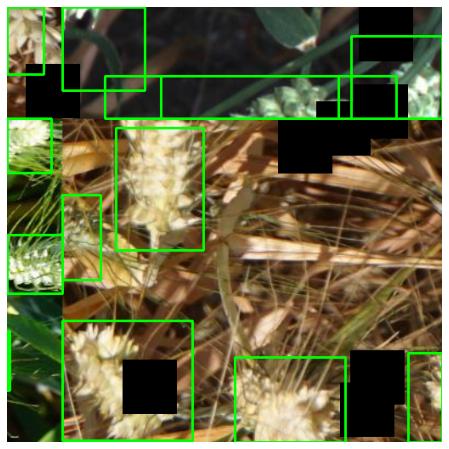

In [27]:

image, target, image_id = training_dataset[np.random.randint(2000)]
print(target['boxes'].shape[0] == target['labels'].shape[0])
boxes = target['boxes'].cpu().numpy().astype(np.int32)
#converting the image from 1024x1024x3 torch tensor to a 1024x3x1024 numpy array
numpy_image = image.permute(1,2,0).cpu().numpy().astype(np.float32)
print(numpy_image.shape)
#plotting

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [28]:
print(len(labeled_files))

13492


## The Network
The network, that will be used here is the 0.14 build of EfficientDet in PyTorch.

### Building the Network
First the network will be configured.


### get_net()

In [29]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

model_type = 'd5'

def get_net():
    #get a starting configuratino for the model
    config = get_efficientdet_config('tf_efficientdet_d5')
    #instantiating the EfficientDet object
    net = EfficientDet(config = config, pretrained_backbone = False)
    #loading a checkpoint
    checkpoint_paths = r'../input/efficientdet/*'+model_type+r'*.pth'
    checkpoint_path = glob(checkpoint_paths)[0]
    checkpoint = torch.load(checkpoint_path)
    #Put the network into the state of the checkpoint
    net.load_state_dict(checkpoint)
    #We only have one class: Wheat
    config.num_classes = 1
    config.image_size = 1024*scale
    #Set up the Head
    #Unfortunately couldn't find out what eps does, since episodes do not make sense, I think
    #momentum chooses the starting direction and intensity of the gradient descent
    net.class_net = HeadNet(config, num_outputs = config.num_classes, norm_kwargs = dict(eps=.001, momentum = 0.1))
    #I think the next step does something similar to compile in keras, but I'm not sure. Maybe it will become apparent later
    return DetBenchTrain(net, config)

### The Training Function

Next the function to train the network will be created. To test the function, however, the dataset has to be created first.

### The Config Class

This class contains the configuration settings for the network. This class is pretty simple and it just contains settings as attributes, that the fitter and other functions can then get.

In [30]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4
    n_epochs = 40 #n_epochs = 40
    lr = 0.0002 #learning rate
    folder = 'effdet-experimental'
    test = False
    #-------------
    verbose = True
    verbose_step = 1
    #APEX
    mixed_precision = True
    accumulate = 8
    #-------------
    step_scheduler = False #scheduler after optimizer.step
    validation_scheduler = True #scheduler.step after validation
    #---------------
#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    #-------------
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode = 'min',
        factor = 0.5,
        patience = 1,
        verbose = False,
        threshold_mode = 'abs',
        cooldown = 0,
        min_lr = 1e-8,
        eps = 1e-08
    )

In [31]:
def collate_fn(batch):
    return tuple(zip(*batch))

### The Average Meter Class

This class will be used to monitor the loss function and to update the network in between epochs

In [32]:
class AverageMeter(object):
    '''Computes and stores the average and current value'''
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum = val * n
        self.count += n
        self.avg = self.sum / self.count

### Data Loader

In [33]:
train_loader = torch.utils.data.DataLoader(training_dataset,
                                           batch_size=TrainGlobalConfig.batch_size,
                                           pin_memory = False,
                                           drop_last = True,
                                           shuffle = True,
#                                            num_workers = TrainGlobalConfig.num_workers,
                                           collate_fn = collate_fn)

val_loader = torch.utils.data.DataLoader(validation_dataset,
                                         batch_size=TrainGlobalConfig.batch_size,
                                         pin_memory = False,
                                         drop_last = True,
                                         shuffle = True,
                                         
#                                            num_workers = TrainGlobalConfig.num_workers,
                                           collate_fn = collate_fn)

### The Fitter Class

Next a class has to be made in order to fit the model to the training data

In [34]:
class Fitter:
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        self.log_path = f'./{config.folder}/log.txt'
        self.device = device
        self.model = model
        self.model.to(device)
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        
        self.optimizer = torch.optim.AdamW(self.model.parameters(),lr = config.lr)
        self.best_summary_loss = 10**5
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        
        self.mixed_precision = config.mixed_precision
        self.accumulate = config.accumulate
        if self.mixed_precision:
            'initialize amp'
            self.model, self.optimizer = amp.initialize(self.model, self.optimizer, opt_level="O1", verbosity=0)
        self.log(f'Fitter prepared. Device is {torch.cuda.get_device_name(device = self.device)}')
        
    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.today().isoformat()
                print('epoch',self.epoch)
                self.log(f'\n{timestamp}\nLR: {lr}')
            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss : {summary_loss.avg:.5f}, time: {time.time()-t}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')
            t = time.time()
            summary_loss = self.validation(validation_loader)
            
            self.log(f'[RESULT]: VAL. Epoch: {self.epoch}, summay_loss: {summary_loss.avg:.5f}, time:{(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)
                if self.config.validation_scheduler:
                    self.scheduler.step(metrics = summary_loss.avg)
            self.epoch += 1
    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        for step, (images, targets , image_ids) in enumerate(train_loader):
            images = torch.stack(images)
            images = images.cuda()
            batch_size = images.shape[0]
            boxes = [target['boxes'].cuda().float() for target in targets]
            lbls = [target['labels'].cuda().float() for target in targets]
            target_res = {}
            target_res['bbox'] = boxes
            target_res['cls'] = lbls
            target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size,
                                                  dtype=torch.float).to(self.device)
            self.optimizer.zero_grad()
            loss = self.model(images, target_res)['loss']
            if self.mixed_precision:
                with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            if (step+1) % self.accumulate == 0:
                self.optimizer.step()
                self.optimizer.zero_grad()    
            
            summary_loss.update(loss.detach().item(), batch_size)
            self.optimizer.step()
            if self.config.step_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)
        return summary_loss
    
    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.cuda().float()
                boxes = [target['boxes'].cuda().float() for target in targets]
                lbls = [target['labels'].cuda().float() for target in targets]
                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = lbls
                target_res['img_scale'] = torch.tensor([1.0] * batch_size, dtype = torch.float32).to(self.device)
                target_res['img_size'] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float32).to(self.device)
                self.optimizer.zero_grad()
                loss = self.model(images, target_res)['loss']
                summary_loss.update(loss.detach().item(),batch_size)
        return summary_loss
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')
    def save(self, path):
        self.model.eval()
        if self.mixed_precision:
            torch.save({
                'model_state_dict': self.model.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
                'epoch':self.epoch,
                'amp': amp.state_dict()
            }, path)
        else:
            torch.save({
                'model_state_dict': self.model.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
                'epoch':self.epoch,
            }, path)
            
        
    def load(self, path):
        if self.config.verbose:
            print('loading started.')
            t0 = time.time()
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        amp.load_state_dict(checkpoint['amp'])
        
        del checkpoint
        import gc
        gc.collect()
        if self.config.verbose:
            print(f'loading done. Time: {time.time()-t0}')

In [35]:
folder = TrainGlobalConfig.folder
f'{folder}'
glob(f'{folder}*')
file = f'{folder}/last-checkpoint.bin'




validation

### Run Training

In [36]:
def run_training():
    device = torch.device('cuda:0')
    
    
    fitter = Fitter(model=net, device = device, config = TrainGlobalConfig)
    fitter.load(file)
    fitter.fit(train_loader, val_loader)

In [37]:
net = get_net()

In [38]:
run_training()

Fitter prepared. Device is GeForce RTX 2080 Ti
loading started.
loading done. Time: 1.0159423351287842
epoch 17

2020-08-04T22:36:40.784095
LR: 0.0002


KeyboardInterrupt: 

## Trial